In [273]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [274]:
DATA_FILE = 'Data/HPP_M2_D15.txt'

# Importing data from Solidworks

Opening the Solidworks file and transform it to CSV file

In [275]:
with open(DATA_FILE, 'r') as file:
	lines = file.readlines()

# Replace the first line with the desired header
lines[0] = 'X [m]	Y [m]	Z [m]	Volume [m^3]	Pressure [Pa]\n'

# Write back to the file
with open(DATA_FILE, 'w') as file:
	file.writelines(lines)

# Read the text file using a regular expression for one or more tabs as the separator.
df = pd.read_csv(DATA_FILE, sep=r'\t+', engine='python')

# Save the DataFrame to a CSV file
csv_file = 'Data/Data.csv'
df.to_csv(csv_file, index=False)

print(f"Data successfully converted to {csv_file}")

Data successfully converted to Data/Data.csv


Editing shortly the exported data before using it, reason why it's now call 'Data_HPP_5'

In [276]:
data = pd.read_csv('Data/Data.csv')


# Select only the required columns
data = data[['Y [m]', 'Z [m]', 'Pressure [Pa]']]

# Drop rows with missing values (NaN)
data['Pressure [Pa]'] = data['Pressure [Pa]'].fillna(0)

data = data[data['Z [m]'] >= 0.1].reset_index(drop=True)
 
data.head(10)

,Y [m],Z [m],Pressure [Pa]
0,0.109649,0.115336,2846.54130
1,0.124433,0.114588,2816.34223
2,0.098176,0.139720,2820.76797
3,0.095792,0.157512,2938.60057
4,0.108041,0.135445,2830.24752
5,0.124433,0.135421,2772.72307
6,0.108021,0.156255,2815.50770
7,0.124433,0.156255,2708.73313
8,0.140583,0.114588,2787.09898
9,0.159766,0.114588,2754.25204


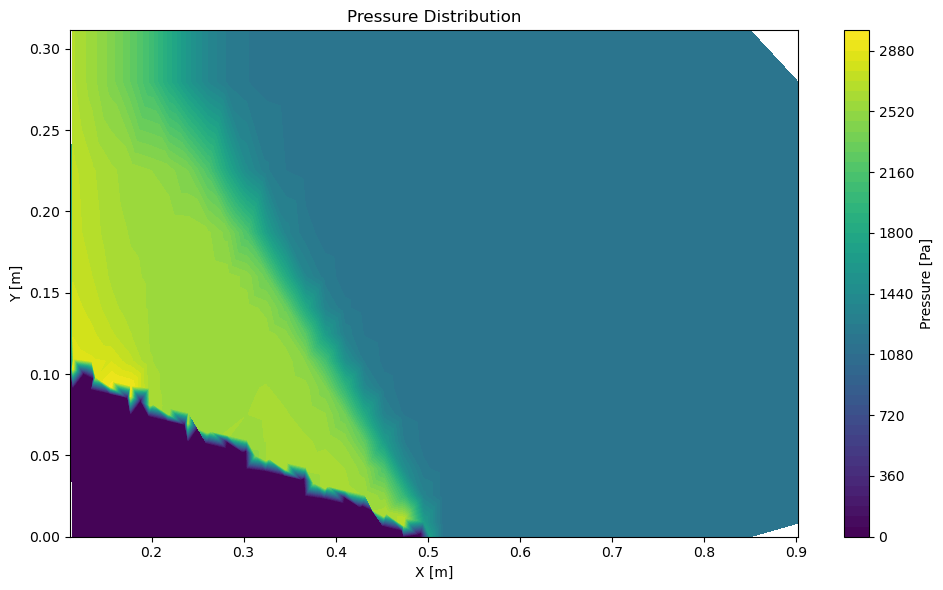

In [277]:
plt.figure(figsize=(10, 6))
contour = plt.tricontourf(data['Z [m]'][data['Pressure [Pa]'].notna()], 
						 data['Y [m]'][data['Pressure [Pa]'].notna()], 
						 data['Pressure [Pa]'][data['Pressure [Pa]'].notna()],
						 levels=50,
						 cmap='viridis')

plt.colorbar(contour, label='Pressure [Pa]')

# Update labels to reflect the swapped axes
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Pressure Distribution')

plt.tight_layout()
plt.show()


# Analysing the data

In [278]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

### Delete the outliers

In [279]:
data_clean = (
	data[['Y [m]', 'Z [m]', 'Pressure [Pa]']]
	.query("`Y [m]` < 0.125")
	.dropna()
	.copy()
)

### Normalising the data

In [280]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_clean)

### K-Means Algorithm

Finding the best K value

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

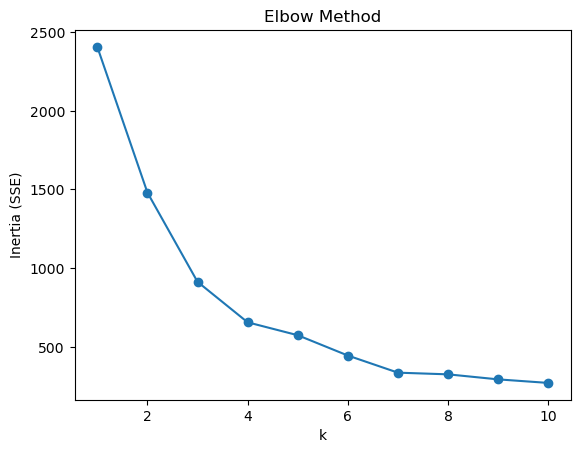

In [281]:
inertias = []
K_range = range(1, 11)          # test 1→10 clusters

for k in K_range:
	km = KMeans(n_clusters=k, random_state=42)
	km.fit(X_scaled)
	inertias.append(km.inertia_)   # sum of intra-cluster distances

plt.plot(K_range, inertias, 'o-')
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.show()

Interpretation of the graph to get the good K-Values.
However here it is known that the number of region should be 3

In [282]:
best_k = 3   # supposons qu'après analyse, 4 est idéal

In [283]:
km_final = KMeans(best_k, random_state=42)
data_clean['cluster'] = km_final.fit_predict(X_scaled)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Creating the border and ploting the results

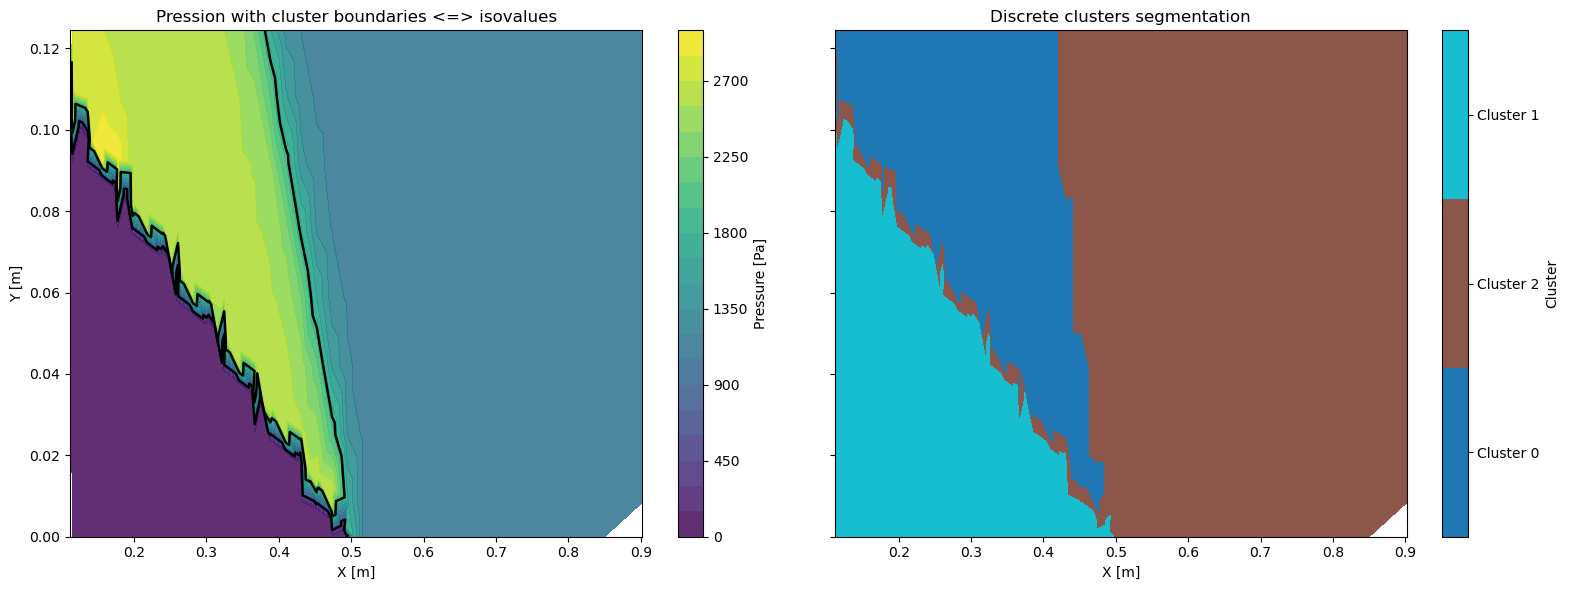

In [284]:
# Nombre de niveaux de pression
level = 25

# Définir les niveaux de pression pour le tracé
centers_scaled   = km_final.cluster_centers_
centers_real     = scaler.inverse_transform(centers_scaled)
centers_pressure = np.sort(centers_real[:, 2]) 
thresholds_pressure = (centers_pressure[:-1] + centers_pressure[1:]) / 2

# Créer une carte de pression lissée
plot_df = data_clean.copy()                  # lignes sans NaN / –1
plot_df['cluster_id'], uniques = pd.factorize(plot_df['cluster'])
n_clusters = len(uniques)

# Affichage
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# A) Zones pleines de cluster (discret)
bounds = np.arange(-0.5, n_clusters + 0.5, 1)
cmap   = plt.get_cmap('tab10', n_clusters)

cs1 = ax1.tricontourf(
    plot_df['Z [m]'], plot_df['Y [m]'], plot_df['cluster_id'],
    levels=bounds, cmap=cmap, extend='neither'
)
ax1.set_title('Discrete clusters segmentation') 
ax1.set_xlabel('X [m]')

cbar1 = fig.colorbar(cs1, ax=ax1, ticks=np.arange(n_clusters))
cbar1.ax.set_yticklabels([f'Cluster {k}' for k in uniques])
cbar1.set_label('Cluster')

# B) Carte de pression + isovaleurs lisses
cs0 = ax0.tricontourf(
    plot_df['Z [m]'], plot_df['Y [m]'], plot_df['Pressure [Pa]'],
    levels=level, cmap='viridis', alpha=0.85, zorder=0
)

ax0.tricontour(
    plot_df['Z [m]'], plot_df['Y [m]'], plot_df['Pressure [Pa]'],
    levels=thresholds_pressure, colors='k', linewidths=1.8, zorder=1
)

ax0.set_title('Pression with cluster boundaries <=> isovalues')
ax0.set_xlabel('X [m]')
ax0.set_ylabel('Y [m]')

cbar0 = fig.colorbar(cs0, ax=ax0)
cbar0.set_label('Pressure [Pa]')

fig.tight_layout(w_pad=3)
plt.show()

### Border Analysis

Keeping only the borders that are in a certain scope and passing by a certain point

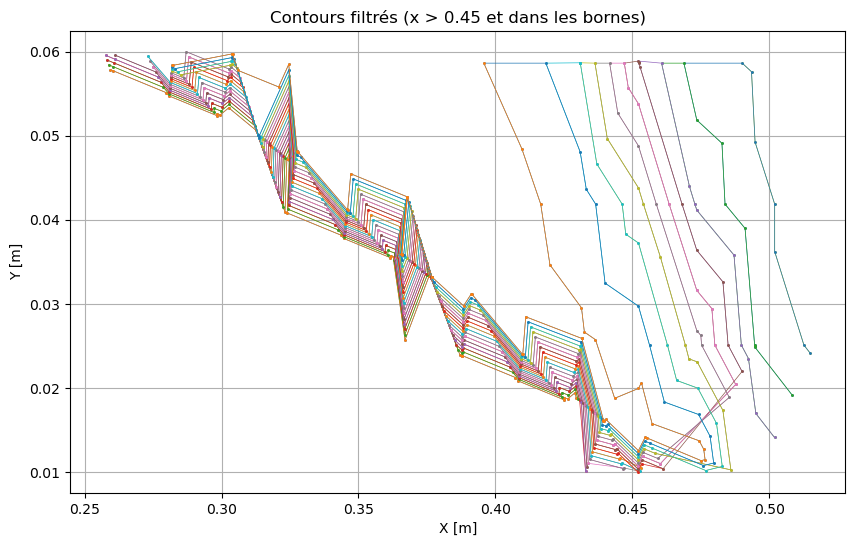

In [285]:
contour_segments = cs0.allsegs

# On réduit la zone d'intérêt à x_min, x_max, y_min, y_max
x_min = 0.2
x_max = 0.6
y_min = 0.01
y_max = 0.06

# On ne garde que les segments qui contiennent au moins une coordonnée x > 0.45
x_importante = 0.45

points_by_level = {}
for level_idx, segments in enumerate(contour_segments):
    filtered_segments = []
    for seg in segments:
        # Ne conserver que les segments qui contiennent au moins une x > 0.45
        if not np.any(seg[:, 0] > x_importante):
            continue

        # Puis appliquer les bornes x_min, x_max, y_min, y_max
        mask = (
            (seg[:, 0] >= x_min) & (seg[:, 0] <= x_max) &
            (seg[:, 1] >= y_min) & (seg[:, 1] <= y_max)
        )
        filtered_seg = seg[mask]
        if filtered_seg.shape[0] > 0:
            filtered_segments.append(filtered_seg)

    points_by_level[level_idx] = filtered_segments

# Affichage
plt.figure(figsize=(10, 6))
for segs in points_by_level.values():
    for seg in segs:
        plt.plot(seg[:, 0], seg[:, 1], 'o-', markersize=1, linewidth=0.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Contours filtrés (x > 0.45 et dans les bornes)')
plt.grid(True)
plt.show()


Removing the points to close one frome each other

In [286]:
thresholds_distance = 0.04  

def deduplicate_points(seg: np.ndarray, thresh: float = thresholds_distance) -> np.ndarray:
    """
    Parcourt un segment (N×2) et ne garde qu'un point par zone de taille thresh×thresh.
    On compare chaque point au dernier point conservé et on l'ajoute uniquement
    si |dx|>thresh ou |dy|>thresh.
    """
    if seg.shape[0] == 0:
        return seg
    cleaned = [seg[0]]
    for p in seg[1:]:
        last = cleaned[-1]
        if abs(p[0] - last[0]) > thresh or abs(p[1] - last[1]) > thresh:
            cleaned.append(p)
    return np.array(cleaned)

# Exemple d'utilisation sur points_by_level avant le découpage
cleaned_segments = []
for segments in points_by_level.values():
    for seg in segments:
        seg_clean = deduplicate_points(seg, thresh=0.002)
        if seg_clean.shape[0] >= 2:
            cleaned_segments.append(seg_clean)


Deleting lines with a slope close to 0

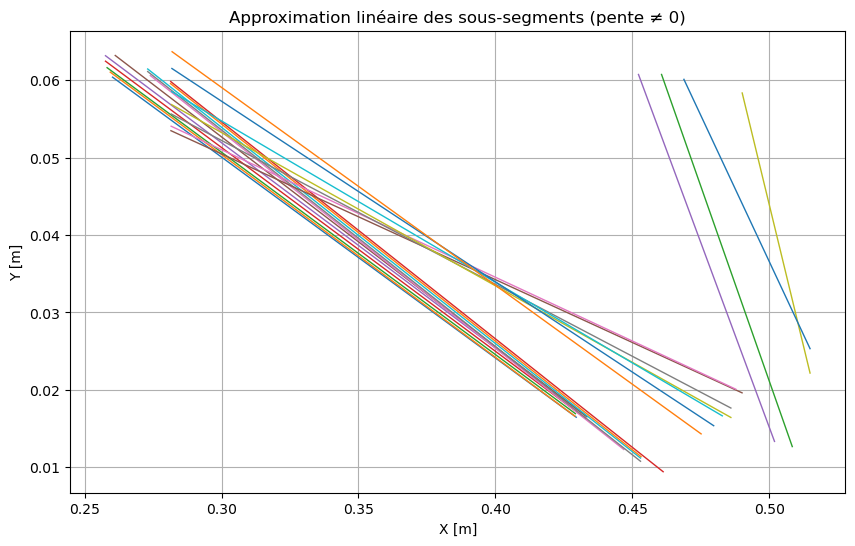

In [287]:
approx_lines = []   
slope_thresh = 0.08  # ajustez ce seuil selon ce que "proche de 0" signifie pour vous

for seg in cleaned_segments:
    # besoin d'au moins 2 points pour faire un fit
    if seg.shape[0] < 2:
        continue

    x = seg[:, 0]
    y = seg[:, 1]

    # Ajustement linéaire y = m*x + b
    m, b = np.polyfit(x, y, 1)

    # Filtrer les droites quasi-plates
    if abs(m) <= slope_thresh:
        continue

    # Extraire les deux extrémités de la droite pour le tracé
    x_line = np.array([x.min(), x.max()])
    y_line = m * x_line + b
    approx_lines.append((x_line, y_line))



# Affichage des droites approximées
plt.figure(figsize=(10, 6))
for x_line, y_line in approx_lines:
    plt.plot(x_line, y_line, '-', linewidth=1)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Approximation linéaire des sous-segments (pente ≠ 0)')
plt.grid(True)
plt.show()


Deleting the slopes that are not passing by y=0 for x=[0.45;0.50]

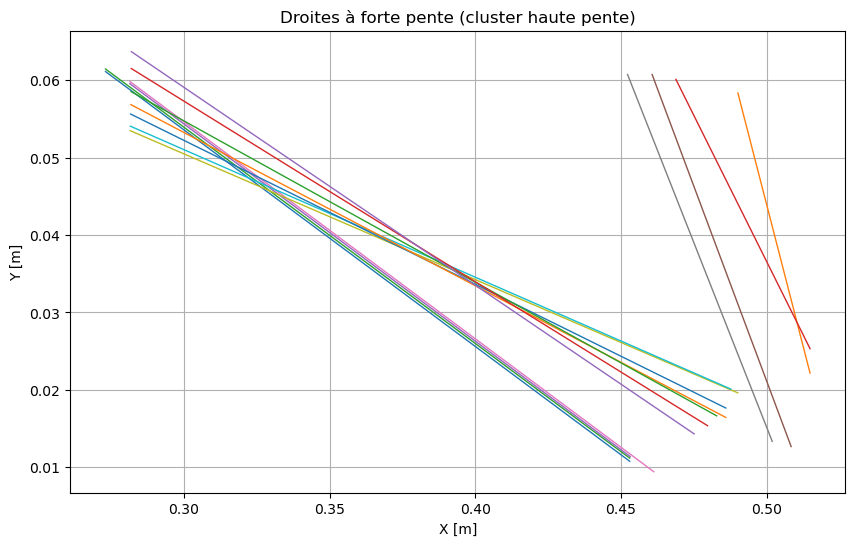

In [288]:
x_min = 0.45
x_max = 0.65
y_min = 0.1

# Étape 1 : filtrer les droites selon la position
filtered_lines = []
slopes = []

for x_line, y_line in approx_lines:
    x0, x1 = x_line
    y0, y1 = y_line
    if (x0 > x_min and x0 < x_max and y0 < y_min) or (x1 > x_min and x1 < x_max and y1 < y_min):
        filtered_lines.append((x_line, y_line))
        if x1 != x0:
            slope = (y1 - y0) / (x1 - x0)
        else:
            slope = float('inf')  # verticale
        slopes.append(abs(slope))  # On prend la pente absolue
        
plt.figure(figsize=(10, 6))
for x_line, y_line in filtered_lines:
    plt.plot(x_line, y_line, '-', linewidth=1)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Droites à forte pente (cluster haute pente)')
plt.grid(True)
plt.show()


K-Means to separate the slopes

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


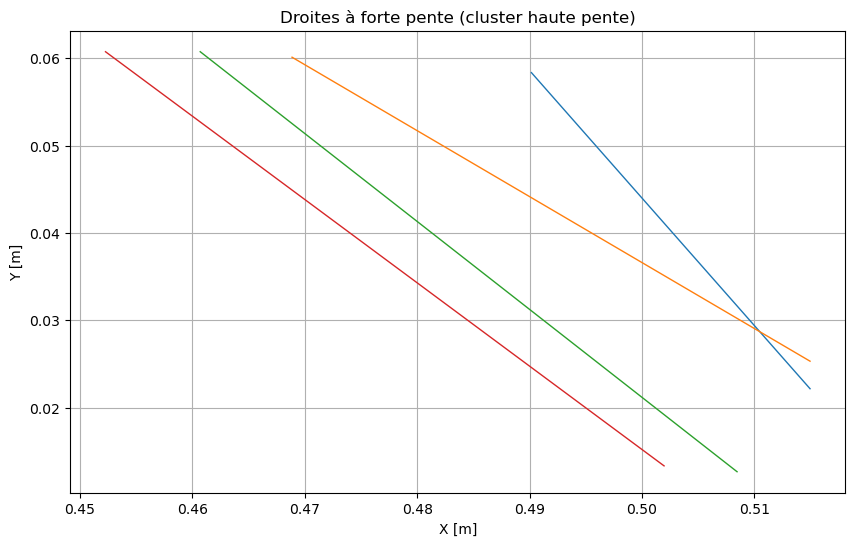

In [289]:
if len(filtered_lines) > 1:
    slopes_array = np.array(slopes).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(slopes_array)
    labels = kmeans.labels_

    # Étape 2 : garder le cluster avec la pente moyenne la plus élevée
    cluster_means = [np.mean(slopes_array[labels == i]) for i in range(2)]
    high_slope_cluster = int(np.argmax(cluster_means))

    # Étape 3 : filtrer les lignes selon le cluster sélectionné
    final_lines = [line for line, label in zip(filtered_lines, labels) if label == high_slope_cluster]
else:
    # Une seule droite : on la garde
    final_lines = filtered_lines

# Affichage
plt.figure(figsize=(10, 6))
for x_line, y_line in final_lines:
    plt.plot(x_line, y_line, '-', linewidth=1)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Droites à forte pente (cluster haute pente)')
plt.grid(True)
plt.show()

Computing the average of the filtred slopes

In [290]:
slopes = []
for x_line, y_line in final_lines:
    # x_line = [x0, x1], y_line = [y0, y1]
    m = (y_line[1] - y_line[0]) / (x_line[1] - x_line[0])
    slopes.append(m)

# moyenne des pentes
mean_slope = np.mean(slopes)
print(f"Coefficient directeur moyen des droites : {mean_slope:.6f}")


Coefficient directeur moyen des droites : -1.044030


Converting the slope into angle

In [291]:
# Conversion de la pente en angle en degrés
angle_rad = np.arctan(mean_slope)
angle_deg = abs(np.degrees(angle_rad))

print(f"Pente moyenne : {mean_slope:.6f}")
print(f"Angle moyen : {angle_deg:.2f}°")

Pente moyenne : -1.044030
Angle moyen : 46.23°


Plot the slope into the pressure field

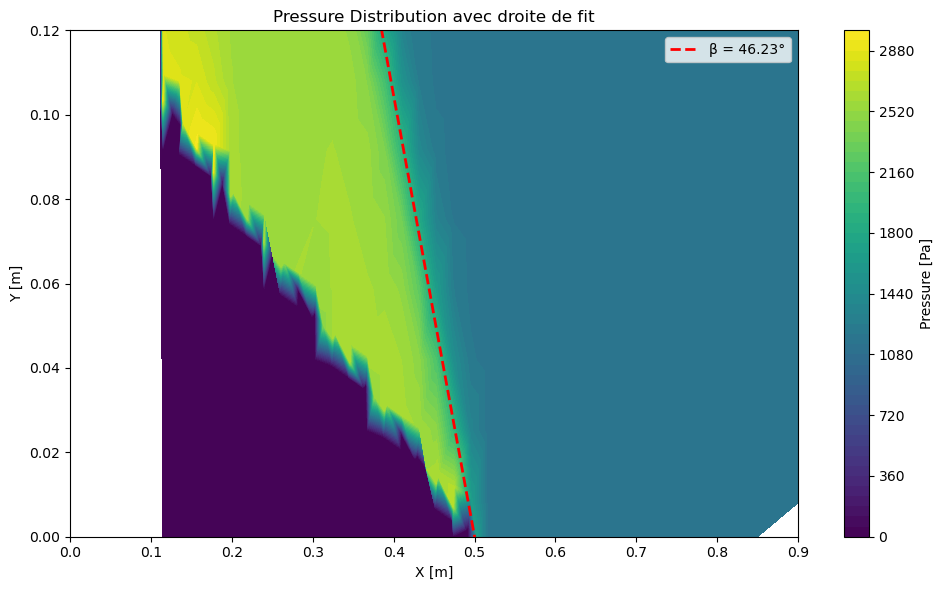

In [292]:
plt.figure(figsize=(10, 6))
contour = plt.tricontourf(
    data['Z [m]'][data['Pressure [Pa]'].notna()],
    data['Y [m]'][data['Pressure [Pa]'].notna()],
    data['Pressure [Pa]'][data['Pressure [Pa]'].notna()],
    levels=50,
    cmap='viridis'
)
plt.colorbar(contour, label='Pressure [Pa]')

# 3) Droite y = mean_slope * (x - 0.5) tracée entre 0 et 0.9
x_vals = np.array([0, 0.9])
y_vals = mean_slope * (x_vals - 0.5)
plt.plot(
    x_vals, y_vals,
    'r--', linewidth=2,
    label=f'β = {angle_deg:.2f}°'
)

# 4) Contrainte des axes
plt.xlim(0, 0.9)
plt.ylim(0, 0.12)

# 5) Légendes et affichage
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Pressure Distribution avec droite de fit')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
